#Libraries

In [ ]:
import numpy as np
import os
import pandas as pd
from sklearn.datasets import load_files
import nltk
import re
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split  
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.feature_selection import mutual_info_classif
from matplotlib import pyplot as plt
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report, precision_recall_curve, auc, f1_score
import warnings
warnings.filterwarnings("ignore")
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, GRU, Embedding
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras.layers import Layer
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import pickle
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.preprocessing import LabelBinarizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install keras-tuner --upgrade

In [ ]:
import keras_tuner as kt

# **BASELINES**

## Preprocessing

Loading the review-files and their assigned class, 0 for negative and 1 for positive

In [ ]:
!wget http://www.cs.cornell.edu/people/pabo/movie-review-data/mix20_rand700_tokens_0211.tar
!tar xvzf mix20_rand700_tokens_0211.tar

movies = load_files(container_path="tokens") 
x, y = movies.data, movies.target

--2022-03-18 19:25:20--  http://www.cs.cornell.edu/people/pabo/movie-review-data/mix20_rand700_tokens_0211.tar
Resolving www.cs.cornell.edu (www.cs.cornell.edu)... 132.236.207.36
Connecting to www.cs.cornell.edu (www.cs.cornell.edu)|132.236.207.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2194052 (2.1M) [application/x-gzip]
Saving to: ‘mix20_rand700_tokens_0211.tar.1’

mix20_rand700_token 100%[===================>]   2.09M  4.30MB/s    in 0.5s    

2022-03-18 19:25:20 (4.30 MB/s) - ‘mix20_rand700_tokens_0211.tar.1’ saved [2194052/2194052]

diff.txt
README
tokens/
tokens/neg/
tokens/neg/cv303_tok-11557.txt
tokens/neg/cv000_tok-9611.txt
tokens/neg/cv001_tok-19324.txt
tokens/neg/cv002_tok-3321.txt
tokens/neg/cv003_tok-13044.txt
tokens/neg/cv004_tok-25944.txt
tokens/neg/cv005_tok-24602.txt
tokens/neg/cv006_tok-29539.txt
tokens/neg/cv007_tok-11669.txt
tokens/neg/cv008_tok-11555.txt
tokens/neg/cv009_tok-19587.txt
tokens/neg/cv010_tok-2188.txt
tokens/neg/cv011_t

In [ ]:
# First sample and target
print('Sample: {} \nTarget: {}'.format(x[1], y[1]))   # 1 positive, 0 negative

Sample: b'cast : russell crowe , joaquin phoenix , connie nielsen , oliver reed , derek jacobi , djimon hounsou , richard harris , spencer treat clark written by : david h . franzoni , john logan and william nicholson directed by : ridley scott running time : 157 minutes roman emperor marcus aurelius ( richard harris ) chooses his trusted general maximus ( russell crowe ) as his successor . however the emperor\'s evil son commodus ( joaquin phoenix ) murders his father before the announcement can be made , and maximus ( as well as his family ) is sentenced to be executed . maximus is able to escape his executioners , but is later captured and sold as a slave to proximo ( oliver reed ) . proximo is looking for gladiators to earn himself money ( he being a former gladiator himself ) , and maximus reluctantly uses his skills to prove himself a powerful gladiator . when emperor commodus announces that new games will be held in the colisseum , proximo takes his gladiators there to do battle

Removing unecessary characters from the data

In [ ]:
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

docs = []
docs_str=""

for doc in x: 
    
    # Remove non-word (special) characters such as punctuation, numbers etc
    document = re.sub(r'\W', ' ', str(doc))              # \W matches any single letter, number or underscore

    document = re.sub(r'[0-9]',' ', document)

    # Remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)  # unnecessary
    
    #Remove the bs from the begining.
    document = re.sub(r'^[a-zA-Z]\s+', ' ', document)
    # Substitute multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I) # \s+ means a string of whitespace characters

    # Remove all numbers
    #document = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", document)

    # Convert to Lowercase
    document = document.lower()

    # Split the document based on whitespaces (--> List of words)
    document = document.split()
    
    # Lemmatization
    document = [lemmatizer.lemmatize(word) for word in document]
    
    # Reconstruct the document by joining the words on each whitespace
    document = ' '.join(document)

    # Append all documents into a list 'docs'
    docs.append(document)
    docs_str = ''.join(document)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Average document length

In [ ]:
lengths = []
for document in docs:
  lengths.append(len(document))
print(f"The average review length is {int(np.mean(lengths))} characters.")

The average review length is 3560 characters.


Average document length per class

In [ ]:
lengths_negative = []
lengths_positive = []
for i in range(len(docs)):
  if y[i] == 0:
      lengths_negative.append(len(docs[i]))
  else:
      lengths_positive.append(len(docs[i]))
print(f"The average review length for the negative class is {int(np.mean(lengths_negative))} characters.")
print(f"The average review length for the positive class is {int(np.mean(lengths_positive))} characters.")
print(f"The minimum review length for the negative class is {int(min(lengths_negative))} characters.")
print(f"The minimum review length for the positive class is {int(min(lengths_positive))} characters.")
print(f"The max review length for the negative class is {int(max(lengths_negative))} characters.")
print(f"The max review length for the positive class is {int(max(lengths_positive))} characters.")

The average review length for the negative class is 3346 characters.
The average review length for the positive class is 3772 characters.
The minimum review length for the negative class is 380 characters.
The minimum review length for the positive class is 476 characters.
The max review length for the negative class is 10109 characters.
The max review length for the positive class is 9919 characters.


In [ ]:
tokenized_sents = [word_tokenize(i) for i in docs]
tokenized_sents = [item for sublist in tokenized_sents for item in sublist]
print("The vocabulary consists of",str(len(np.unique(tokenized_sents)))+" words.")

The vocabulary consists of 30797 words.


Train test dev split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(docs, y, test_size=0.2, random_state=13579)

x_train, x_dev, y_train, y_dev = train_test_split(x_train, y_train, test_size=0.25, random_state=13579)

In [ ]:
stop_words = list(set(stopwords.words('english')))

In [ ]:
x_train[0]

'mr nice guy is the latest jackie chan film so you should know what to expect weak plot terrible dialogue very little acting ability but some jaw dropping action sequence that nearly make the rest of it worthwhile however mr nice guy lack the sparkle of jackie best effort and it weakness are more glaring than ever jackie chan play who else jackie this time out he a famous chef who host an australian cooking show not that it ever make difference in the plot there are only two scene of him cooking for the rest of the film somehow he mutates into jackie chan supercop it never doe explain why his character ha such superb martial art skill perhaps he wa in the same cooking class a steven seagal in under siege tv newswoman diana gabrielle fitzpatrick covertly tape drug deal involving kingpin giancarlo richard norton and local gang of tough the demon although she only ha one camcorder somehow the result is full of close ups and multiple angle hmmm shade of broadcast news anyway the goon disco

In [ ]:
# Use unigram & bi-gram tf*idf features
vectorizer = TfidfVectorizer(ngram_range = (1, 2), max_features = 5000, sublinear_tf = True, stop_words = stopwords.words('english'))

# Transform on all data (train - test)
x_train_tfidf = vectorizer.fit_transform(x_train)
x_test_tfidf = vectorizer.transform(x_test)
x_dev_tfidf = vectorizer.transform(x_dev)

print(vectorizer.get_feature_names())

['abandon', 'abandoned', 'ability', 'able', 'absent', 'absolute', 'absolutely', 'absurd', 'abuse', 'abyss', 'academy', 'academy award', 'accent', 'accept', 'acceptable', 'accident', 'accidentally', 'acclaimed', 'accomplished', 'according', 'account', 'accurate', 'accused', 'achieve', 'achievement', 'acid', 'across', 'act', 'acted', 'acting', 'acting ability', 'action', 'action comedy', 'action film', 'action hero', 'action movie', 'action scene', 'action sequence', 'action star', 'action thriller', 'activity', 'actor', 'actress', 'actual', 'actually', 'ad', 'adam', 'adam sandler', 'adaptation', 'adapted', 'add', 'added', 'adding', 'addition', 'address', 'admire', 'admit', 'admittedly', 'adult', 'advance', 'advanced', 'advantage', 'adventure', 'advice', 'affair', 'affected', 'affection', 'affleck', 'aforementioned', 'afraid', 'africa', 'african', 'african american', 'afterwards', 'age', 'aged', 'agent', 'aging', 'ago', 'agree', 'agrees', 'ah', 'ahead', 'aid', 'aim', 'aimed', 'air', 'air

We implement SVD to reduce the components to 100 (dimension of each vector).

In [ ]:
# Reduce dimensionality using svd from 5000 to 100
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=100, random_state=1212)
x_train_svd = svd.fit_transform(x_train_tfidf)
x_dev_svd = svd.transform(x_dev_tfidf)
x_test_svd = svd.transform(x_test_tfidf)

In [ ]:
print(f"Shape of the train set after the SVD dimensionality reduction is: {x_train_svd.shape}")

Shape of the train set after the SVD dimensionality reduction is: (831, 100)


We are going to set **three baselines**.<br>For all three baselines, **Dummy (majority) Classifier, Logistic Regression and MLP**, SVD is implemented on the TF-IDF train, dev and test sets.

## Baseline 1: Dummy Classifier

In [ ]:
def set_baseline(baseline):
  # Evaluate
  predictions = baseline.predict(x_train_svd)
  score = accuracy_score(y_train, predictions)
  pred_train = baseline.predict_proba(x_train_svd)
  print("Train accuracy: {:.2f}%".format(score*100))

  predictions_dev = baseline.predict(x_dev_svd)
  score = accuracy_score(y_dev, predictions_dev)
  pred_dev = baseline.predict_proba(x_dev_svd)
  print("Dev accuracy: {:.2f}% ".format(score*100))

  predictions_test = baseline.predict(x_test_svd)
  score = accuracy_score(y_test, predictions_test)
  pred_test = baseline.predict_proba(x_test_svd)
  print("Test accuracy: {:.2f}% \n".format(score*100))

  print('#Class 0 in Train dataset:', np.where(y_train == 0)[0].shape)
  print('#Class 1 in Train dataset:', np.where(y_train == 1)[0].shape)

  #Train Set
  print("\nPrecision, recall, F1 scores for each class(train set)")
  print(classification_report(y_train, predictions,labels=np.array([0,1])))
  print("\nPrecision Recall AUC score for the negative class(train set):")
  precision, recall, thresholds = precision_recall_curve(y_train, pred_train[:,0],pos_label=0)
  area_train_1 = auc(recall, precision)
  print(area_train_1)
  print("\nPrecision Recall AUC score for the positive class(train set):")
  precision, recall, thresholds = precision_recall_curve(y_train, pred_train[:,1],pos_label=1)
  area_train_2 = auc(recall, precision)
  print(area_train_2)
  print("\nMacro-averaged Precision Recall AUC score for the train set:")
  print((area_train_1+area_train_2)/2)
  #Dev Set
  print("\nPrecision, recall, F1 scores for each class(dev set)")
  print(classification_report(y_dev, predictions_dev,labels=np.array([0,1])))
  print("\nPrecision Recall AUC score for the negative class(dev set):")
  precision, recall, thresholds = precision_recall_curve(y_dev, pred_dev[:,0],pos_label=0)
  area_train_1 = auc(recall, precision)
  print(area_train_1)
  print("\nPrecision Recall AUC score for the positive class(dev set):")
  precision, recall, thresholds = precision_recall_curve(y_dev, pred_dev[:,1],pos_label=1)
  area_train_2 = auc(recall, precision)
  print(area_train_2)
  print("\nMacro-averaged Precision Recall AUC score for the dev set:")
  print((area_train_1+area_train_2)/2)
  #Test Set
  print("\nPrecision, recall, F1 scores for each class(test set)")
  print(classification_report(y_test, predictions_test,labels=np.array([0,1])))
  print("\nPrecision Recall AUC score for the negative class (test set):")
  precision, recall, thresholds = precision_recall_curve(y_test, pred_test[:,0],pos_label=0)
  area_train_1 = auc(recall, precision)
  print(area_train_1)
  print("\nPrecision Recall AUC score for the positive class (test set):")
  precision, recall, thresholds = precision_recall_curve(y_test, pred_test[:,1],pos_label=1)
  area_train_2 = auc(recall, precision)
  print(area_train_2)
  print("\nMacro-averaged Precision Recall AUC score for the test set:")
  print((area_train_1+area_train_2)/2)


  print("\nConfusion Matrix for test data:")
  plot_confusion_matrix(estimator=baseline, X=x_test_svd, y_true=y_test, values_format = '.0f')

Baseline Dummy (majority) Classifier
Train accuracy: 51.14%
Dev accuracy: 49.46% 
Test accuracy: 46.76% 

#Class 0 in Train dataset: (425,)
#Class 1 in Train dataset: (406,)

Precision, recall, F1 scores for each class(train set)
              precision    recall  f1-score   support

           0       0.51      1.00      0.68       425
           1       0.00      0.00      0.00       406

    accuracy                           0.51       831
   macro avg       0.26      0.50      0.34       831
weighted avg       0.26      0.51      0.35       831


Precision Recall AUC score for the negative class(train set):
0.7557160048134777

Precision Recall AUC score for the positive class(train set):
0.7442839951865223

Macro-averaged Precision Recall AUC score for the train set:
0.75

Precision, recall, F1 scores for each class(dev set)
              precision    recall  f1-score   support

           0       0.49      1.00      0.66       137
           1       0.00      0.00      0.00      

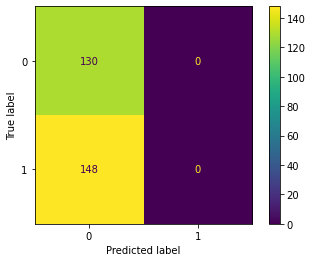

In [ ]:
baseline = DummyClassifier(strategy='most_frequent')

baseline.fit(x_train_svd, y_train)
print("Baseline Dummy (majority) Classifier")
set_baseline(baseline)

## Baseline 2: Best model from the second assignment, Logistic Regression

Baseline Logistic Regression
Train accuracy: 85.44%
Dev accuracy: 77.98% 
Test accuracy: 78.42% 

#Class 0 in Train dataset: (425,)
#Class 1 in Train dataset: (406,)

Precision, recall, F1 scores for each class(train set)
              precision    recall  f1-score   support

           0       0.85      0.86      0.86       425
           1       0.86      0.84      0.85       406

    accuracy                           0.85       831
   macro avg       0.85      0.85      0.85       831
weighted avg       0.85      0.85      0.85       831


Precision Recall AUC score for the negative class(train set):
0.9323941651005087

Precision Recall AUC score for the positive class(train set):
0.9335693519530497

Macro-averaged Precision Recall AUC score for the train set:
0.9329817585267792

Precision, recall, F1 scores for each class(dev set)
              precision    recall  f1-score   support

           0       0.76      0.81      0.78       137
           1       0.80      0.75      0.77

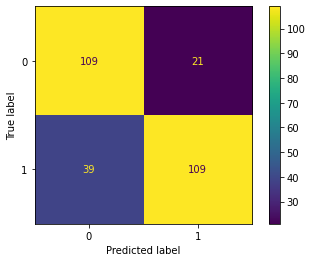

In [ ]:
# Solver -- Algorithm to use in the optimization problem.
clf = LogisticRegression(solver="liblinear", C=1, max_iter=100, tol=0.0001)
clf.fit(x_train_svd, y_train)
print("Baseline Logistic Regression")
set_baseline(clf)

## MLP Baseline

Choice of approach: Architecture of the MLP from **scratch** based on the best parameter values provided by the Keras-tuner results.

In [ ]:
model = Sequential()
model.add(Dense(512, input_dim=x_train_svd.shape[1], activation='relu'))
model.add(Dense(512,  activation='relu'))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

model.compile(
      loss='binary_crossentropy', # Cross-entropy is the default loss function to use for binary classification problems!!!!!!!!!
      metrics=["accuracy"]
      )

history2 = model.fit(x_train_svd, y_train, epochs=40, callbacks=callbacks, validation_data=(x_dev_svd, y_dev)) # early_stopping_monitor.stopped_epoch
# max(history.history['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               51712     
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 1)                 513       
                                                                 
Total params: 314,881
Trainable params: 314,881
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/40
26/26 [==============================] - 1s 17ms/step - loss: 0.6304 - accuracy: 0.6655 - val_loss: 0.5743 - val_accuracy: 0.7509 - lr: 0.0010
Epoch 2/40
26/26 [==============================] - 0s 15ms/step - loss: 0.4232 - accuracy: 0.8195 - val_loss: 0.4755 - val_accuracy: 0.7942 - lr: 0.0010
E

In [ ]:
model.evaluate(x_train_svd, y_train)

26/26 [==============================] - 0s 6ms/step - loss: 0.0869 - accuracy: 0.9795


[0.08685378730297089, 0.9795427322387695]

In [ ]:
model.evaluate(x_dev_svd, y_dev)

9/9 [==============================] - 0s 5ms/step - loss: 0.4213 - accuracy: 0.8231


[0.4212924540042877, 0.8231046795845032]

In [ ]:
model.evaluate(x_test_svd, y_test)

9/9 [==============================] - 0s 5ms/step - loss: 0.4396 - accuracy: 0.8094


[0.4395875930786133, 0.8093525171279907]

Experimental characteristics-results of the MLP

In [ ]:
def report(x, y, set_type):
  probs_belong_to_class_1 = model.predict(x)
  probs_belong_to_class_0 = 1-probs_belong_to_class_1
  predict_proba_preds = np.concatenate((probs_belong_to_class_0, probs_belong_to_class_1), axis = 1)

  print(f"\nPrecision, recall, F1 scores for each class({set_type} set)")
  print(classification_report(y, np.round(model.predict(x)).astype("int32"), labels=np.array([0,1])))
                                    # (model.predict(x_train_svd) >= 0.5).astype("int32")

  print(f"\nPrecision Recall AUC score for the negative class({set_type} set):")
  precision, recall, thresholds = precision_recall_curve(y, predict_proba_preds[:,0],pos_label=0)
  area_train_1 = auc(recall, precision)
  print(area_train_1)
  print(f"\nPrecision Recall AUC score for the positive class({set_type} set):")
  precision, recall, thresholds = precision_recall_curve(y, predict_proba_preds[:,1],pos_label=1)
  area_train_2 = auc(recall, precision)
  print(area_train_2)
  print(f"\nMacro-averaged Precision Recall AUC score for the {set_type} set:")
  print((area_train_1+area_train_2)/2)

Results of the train set:

In [ ]:
# Train set
report(x_train_svd, y_train, "train")


Precision, recall, F1 scores for each class(train set)
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       425
           1       0.95      0.89      0.92       406

    accuracy                           0.93       831
   macro avg       0.93      0.93      0.93       831
weighted avg       0.93      0.93      0.93       831


Precision Recall AUC score for the negative class(train set):
0.9831038371925986

Precision Recall AUC score for the positive class(train set):
0.9831022409623265

Macro-averaged Precision Recall AUC score for the train set:
0.9831030390774625


Results of the dev set:

In [ ]:
# Dev set
report(x_dev_svd, y_dev, "dev")


Precision, recall, F1 scores for each class(dev set)
              precision    recall  f1-score   support

           0       0.78      0.80      0.79       137
           1       0.80      0.78      0.79       140

    accuracy                           0.79       277
   macro avg       0.79      0.79      0.79       277
weighted avg       0.79      0.79      0.79       277


Precision Recall AUC score for the negative class(dev set):
0.8817744263240535

Precision Recall AUC score for the positive class(dev set):
0.8605324574738351

Macro-averaged Precision Recall AUC score for the dev set:
0.8711534418989443


Results of the test set:

In [ ]:
# Test set
report(x_test_svd, y_test, "test")


Precision, recall, F1 scores for each class(test set)
              precision    recall  f1-score   support

           0       0.77      0.85      0.81       130
           1       0.85      0.78      0.82       148

    accuracy                           0.81       278
   macro avg       0.81      0.81      0.81       278
weighted avg       0.82      0.81      0.81       278


Precision Recall AUC score for the negative class(test set):
0.8558188004118252

Precision Recall AUC score for the positive class(test set):
0.9040022024642915

Macro-averaged Precision Recall AUC score for the test set:
0.8799105014380584


# **RNN**

## **Preprocessing**




Loading the review-files and their assigned class, 0 for negative and 1 for positive

In [ ]:
movies = load_files(container_path="tokens") 
x, y = movies.data, movies.target

Removing unecessary characters from the data

In [ ]:
nltk.download('wordnet')

docs = []
docs_str=""

for doc in x: 
    
    # Remove non-word (special) characters such as punctuation, numbers etc
    document = re.sub(r'\W', ' ', str(doc))              # \W matches any single letter, number or underscore

    document = re.sub(r'[0-9]',' ', document)

    # Remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)  # unnecessary
    
    #Remove the bs from the begining.
    document = re.sub(r'^[a-zA-Z]\s+', ' ', document)
    # Substitute multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I) # \s+ means a string of whitespace characters

    # Convert to Lowercase
    document = document.lower()

    # Split the document based on whitespaces (--> List of words)
    document = document.split()
    
    # Reconstruct the document by joining the words on each whitespace
    document = ' '.join(document)

    # Append all documents into a list 'docs'
    docs.append(document)
    docs_str = ''.join(document)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Train, Test, Dev Split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(docs, y, test_size=0.2, random_state=13579)

x_train, x_dev, y_train, y_dev = train_test_split(x_train, y_train, test_size=0.25, random_state=13579)

#### **Download, unzip & load fasttext word embeddings**

In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
!gzip -d cc.en.300.vec.gz

--2022-03-18 19:26:25--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 104.22.74.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1325960915 (1.2G) [binary/octet-stream]
Saving to: ‘cc.en.300.vec.gz’

cc.en.300.vec.gz    100%[===================>]   1.23G  50.3MB/s    in 27s     

2022-03-18 19:26:52 (46.1 MB/s) - ‘cc.en.300.vec.gz’ saved [1325960915/1325960915]

gzip: cc.en.300.vec already exists; do you wish to overwrite (y or n)? y


#### **Load fasttext embeddings**
To load fasttext pre-trained embeddings more efficiently, we can read only once the embeddings file and save:

1. A 2D np-array for the embedding vectors
2. A dictionary that maps each word to the row index of its embedding on the 2D np-array

In [ ]:
idx = 0
vocab = {}
# Save embeddings to numpy array (vocab_size x dimensions)
# We manually add 2 special tokens (for padding & unknown words)
with open("cc.en.300.vec", 'r', encoding="utf-8", newline='\n',errors='ignore') as f:
    for l in f:
        line = l.rstrip().split(' ')
        if idx == 0:
            vocab_size = int(line[0]) + 2
            dim = int(line[1])
            vecs = np.zeros(vocab_size*dim).reshape(vocab_size,dim)
            vocab["__PADDING__"] = 0
            vocab["__UNK__"] = 1
            idx = 2
        else:
            vocab[line[0]] = idx
            emb = np.array(line[1:]).astype(np.float)
            if (emb.shape[0] == dim):
                vecs[idx,:] = emb  # Embeddings are saved in an numpy array vecs
                idx+=1
            else:
                continue

    # Serialize vocab & embeddings
    pickle.dump(vocab,open("/content/drive/MyDrive/fasttext_voc.pkl" ,'wb'))
    np.save("/content/drive/MyDrive/fasttext.npy",vecs)
    
    # Free ram
    vecs = None
    vocab = None
    emb = None

In [ ]:
fasttext_embed = np.load("/content/drive/MyDrive/fasttext.npy")
fasttext_word_to_index = pickle.load(open("/content/drive/MyDrive/fasttext_voc.pkl", 'rb'))

#### **Use spacy for sentence splitting & tokenization**

In [ ]:
nlp = spacy.load('en_core_web_sm',disable=["tagger", "parser","ner"])
nlp.add_pipe(nlp.create_pipe('sentencizer')) 

def tokenize_samples(samples):
  
  tokenized_samples = []
  for i in range(len(samples)):
    doc = nlp(samples[i])  # Tokenize the sample into sentences
    tokens = []
    for sent in doc.sents:
      for tok in sent:  # Iterate through the words of the sentence
        if '\n' in tok.text or "\t" in tok.text or "--" in tok.text or "*" in tok.text or tok.text.lower() in STOP_WORDS:
          continue
        if tok.text.strip():  
          tokens.append(tok.text.replace('"',"'").strip())
    tokenized_samples.append(tokens)

  return tokenized_samples

X_train_tokenized = tokenize_samples(x_train)
X_val_tokenized = tokenize_samples(x_dev)
X_test_tokenized = tokenize_samples(x_test)

In [ ]:
# Get mean and std for length on trainning set
print('Average length of samples: {}'.format(np.mean([len(x) for x in X_train_tokenized])))
print('Std length of samples: {}'.format(np.std([len(x) for x in X_train_tokenized])))
print('#Samples with length > 100: {} \n'.format(np.sum([len(x) > 1000 for x in X_train_tokenized])))
print('X_example: {}'.format(X_train_tokenized[0]))

Average length of smples: 322.36943441636583
Std length of samples: 136.93265881044567
#Samples with length > 100: 0 

X_example: ['mr', 'nice', 'guy', 'latest', 'jackie', 'chan', 'film', 'know', 'expect', 'weak', 'plot', 'terrible', 'dialogue', 'little', 'acting', 'ability', 'jaw', 'dropping', 'action', 'sequences', 'nearly', 'rest', 'worthwhile', 'mr', 'nice', 'guy', 'lacks', 'sparkle', 'jackie', 'best', 'efforts', 'weaknesses', 'glaring', 'jackie', 'chan', 'plays', 'jackie', 'time', 'famous', 'chef', 'hosts', 'australian', 'cooking', 'makes', 'difference', 'plot', 'scenes', 'cooking', 'rest', 'film', 'mutates', 'jackie', 'chan', 'supercop', 'explain', 'character', 'superb', 'martial', 'arts', 'skills', 'cooking', 'class', 'steven', 'seagal', 'siege', 'tv', 'newswoman', 'diana', 'gabrielle', 'fitzpatrick', 'covertly', 'tapes', 'drug', 'deal', 'involving', 'kingpin', 'giancarlo', 'richard', 'norton', 'local', 'gang', 'toughs', 'demons', 'camcorder', 'result', 'close', 'ups', 'multiple

#### **Convert labels to 1-hot vectors**

In [ ]:
lb = LabelBinarizer()
target_list = ['Negative', 'Positive']

y_train_1_hot = lb.fit_transform([target_list[x] for x in y_train])
y_val_1_hot = lb.transform([target_list[x] for x in y_dev])
y_test_1_hot = lb.transform([target_list[x] for x in y_test])

print('Y_example: {}'.format(y_train_1_hot[0]))

Y_example: [0]


#### **Tokenize, convert text (sequence of words) to sequence of indexes and PAD the sequences**

Tensorflow's tokenizer: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer

Tensorflow's pad_sequences: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences

In [ ]:
MAX_WORDS = 1000#WAS 100000 EPAIRNE POLY
MAX_SEQUENCE_LENGTH = 350
EMBEDDING_DIM = fasttext_embed.shape[1]       # --> 300
                                              # .shape[0] --> 2000002
# Init tokenizer
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='__UNK__')
# num_words: the maximum number of words to keep, based on word frequency.
# oov_token: will be used to replace OOV WORDS

# Fit tokenizer (Updates internal vocabulary based on a list of texts.)
tokenizer.fit_on_texts([" ".join(x) for x in X_train_tokenized])

# Converts text to sequences of IDs
train_seqs = tokenizer.texts_to_sequences([" ".join(x) for x in X_train_tokenized])      # --> len > or < 350 (or coincidencally =)
val_seqs = tokenizer.texts_to_sequences([" ".join(x) for x in X_val_tokenized])          # --> len > or < 350 (or coincidencally =)
test_seqs = tokenizer.texts_to_sequences([" ".join(x) for x in X_test_tokenized])

train_data = pad_sequences(train_seqs, maxlen=MAX_SEQUENCE_LENGTH, padding='post')       # --> len=350 --> num_timesteps
val_data = pad_sequences(val_seqs, maxlen=MAX_SEQUENCE_LENGTH, padding='post')           # --> len=350
test_data = pad_sequences(test_seqs, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

In [ ]:
print(train_seqs[11])
print(train_data[11])

[1, 1, 111, 379, 1, 1, 1, 272, 1, 272, 1, 379, 1, 1, 1, 393, 1, 1, 1, 1, 733, 97, 1, 80, 97, 1, 747, 1, 66, 1, 1, 146, 342, 1, 34, 19, 106, 1, 1, 1, 1, 599, 111, 1, 150, 224, 36, 586, 1, 1, 734, 358, 1, 1, 1, 487, 1, 1, 1, 1, 1, 821, 1, 1, 118, 379, 1, 69, 1, 36, 397, 3, 870, 1, 54, 1, 870, 1, 442, 99, 1, 1, 1, 1, 1, 311, 1, 65, 1, 1, 558, 1, 520, 1, 124, 1, 1, 1, 124, 1, 1, 1, 1, 1, 1, 1, 275, 1, 436, 1, 1, 1, 272, 1, 1, 1, 68, 1, 851, 1, 1, 1, 1, 83, 1, 1, 1, 1, 1, 1, 1, 1, 1, 22, 1, 276, 1, 1, 1, 1, 1, 1, 851, 1, 1, 1, 1, 1, 1, 1, 1, 221, 45, 1, 97, 1, 747, 1, 1, 46, 237, 521, 851, 1, 237, 1, 1, 1, 134, 605, 1, 1, 1, 15, 484, 1, 1, 388, 17, 660, 10, 1, 748, 1, 1, 1, 561, 1, 1, 1, 69, 1, 1, 1, 1, 1, 926, 3, 69, 168, 1, 590, 1, 1, 311, 1, 1, 1, 24, 149, 1, 1, 195, 1, 9, 69, 1, 1, 1, 739, 1, 232, 197, 75, 1, 6, 75, 198, 1, 1, 1, 156, 1, 1, 450, 121, 1, 1, 10, 1, 1, 1, 1, 69, 941, 367, 344, 1, 1, 577, 1, 2, 742, 1, 1, 1, 1, 329, 1, 1, 1, 40, 1, 1, 419, 116, 1, 172, 108, 1, 40, 1, 1, 1, 

In [ ]:
word_index = tokenizer.word_index
print('Found {} unique tokens.\n'.format(len(word_index)))

print(word_index)

Found 27316 unique tokens.

{'__UNK__': 1, 'film': 2, 'movie': 3, 'like': 4, 'time': 5, 'good': 6, 'story': 7, 'n': 8, 'character': 9, 'characters': 10, 'way': 11, 'little': 12, 'people': 13, 'films': 14, 'plot': 15, 'life': 16, 'don': 17, 'director': 18, 'bad': 19, 'scene': 20, 'man': 21, 'movies': 22, 'scenes': 23, 'great': 24, 'best': 25, 'new': 26, 'doesn': 27, 'action': 28, 'know': 29, 'love': 30, 'big': 31, 'john': 32, 'end': 33, 'minutes': 34, 'going': 35, 'cast': 36, 'year': 37, 'makes': 38, 'better': 39, 'com': 40, 'things': 41, 'actually': 42, 'real': 43, 'old': 44, 'think': 45, 'audience': 46, 'gets': 47, 'role': 48, 'work': 49, 've': 50, 'world': 51, 'isn': 52, 'performance': 53, 'comedy': 54, 'seen': 55, 'thing': 56, 'fact': 57, 'long': 58, 'look': 59, 'young': 60, 'years': 61, 'm': 62, 'played': 63, 'comes': 64, 'plays': 65, 'directed': 66, 'right': 67, 'family': 68, 'funny': 69, 'http': 70, 'original': 71, 'find': 72, 'script': 73, 'lot': 74, 'come': 75, 'takes': 76, 'st

In [ ]:
# Previously, we saved all fasttext embeddings to a NumPy array for quick access
# Now, we save the fasttext embeddings for the words that we only need, based on the tokenizer

embedding_matrix = np.zeros((MAX_WORDS+2, EMBEDDING_DIM))  # +2 (pad, unkown)

for word, i in word_index.items():
    if i > MAX_WORDS:
            continue
    try:
        embedding_vector = fasttext_embed[fasttext_word_to_index[word],:]
        embedding_matrix[i] = embedding_vector
    except:
        pass

print(embedding_matrix)

[[ 0.      0.      0.     ...  0.      0.      0.    ]
 [ 0.      0.      0.     ...  0.      0.      0.    ]
 [-0.0305  0.0716  0.0492 ...  0.1654 -0.0834 -0.036 ]
 ...
 [ 0.0334  0.062  -0.0906 ...  0.0348 -0.0584 -0.0572]
 [-0.0554  0.1676 -0.1192 ...  0.0731  0.0759 -0.0495]
 [ 0.      0.      0.     ...  0.      0.      0.    ]]


In [ ]:
np.nonzero(embedding_matrix)
# used to Compute the indices of the elements that are non-zero. It returns a tuple of arrays,
# one for each dimension of arr, containing the indices of the non-zero elements in that dimension.
# The corresponding non-zero values in the array can be obtained with arr[nonzero(arr)] 

(array([   2,    2,    2, ..., 1000, 1000, 1000]),
 array([  0,   1,   2, ..., 297, 298, 299]))

**---------------------------------------------------------------------**

## **Hyper-parameter tuning with Keras-tuner to define the architecture of our BiGRU + MLP model**


In [ ]:
my_dir = os.getcwd()+'/drive/MyDrive/text_analytics_5'

In [ ]:
print('Initial set shapes:')
print(np.shape(x_train_svd))
print(np.shape(y_train))
print(np.shape(x_dev_svd))
print(np.shape(y_dev))
print(np.shape(x_test_svd))
print(np.shape(y_test))

Initial set shapes:
(831, 100)
(831,)
(277, 100)
(277,)
(278, 100)
(278,)


In [ ]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
      return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
      return K.dot(x, kernel)


class LinearAttention(Layer):
    def __init__(self,
                 kernel_regularizer=None, bias_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True,
                 return_attention=False,
                 **kwargs):
        
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(kernel_regularizer)
        self.b_regularizer = regularizers.get(bias_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.return_attention = return_attention
        super(LinearAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight(shape=(1,),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, inputs, mask=None):
        # do not pass the mask to the next layers
        if self.return_attention:
            return [None, None]
        return None

    def call(self, x, mask=None):
        
        # eij = Wx + b
        eij = dot_product(x, self.W)

        if self.bias:
            eij += self.b

        # Apply mask
        if mask is not None:
            eij *= K.cast(mask, K.floatx())

        # a = softmax(eij)
        a = K.expand_dims(K.softmax(eij, axis=-1))
        weighted_input = x * a
        result = K.sum(weighted_input, axis=1)

        if self.return_attention:
            return [result, a]
        return result

    def compute_output_shape(self, input_shape):
        if self.return_attention:
            return [(input_shape[0], input_shape[-1]),
                    (input_shape[0], input_shape[1])]
        else:
            return input_shape[0], input_shape[-1]


class DeepAttention(Layer):
    def __init__(self,
                 kernel_regularizer=None, u_regularizer=None, v_regularizer=None, bias_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None, v_constraint=None,
                 bias=True,
                 return_attention=False, layers=None,
                 **kwargs):
        self.layers = layers
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(kernel_regularizer)
        self.b1_regularizer = regularizers.get(bias_regularizer)
        self.W_constraint = constraints.get(W_constraint)
        self.b1_constraint = constraints.get(b_constraint)
        
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b2_regularizer = regularizers.get(bias_regularizer)
        self.u_constraint = constraints.get(u_constraint)
        self.b2_constraint = constraints.get(b_constraint)

        self.v_regularizer = regularizers.get(v_regularizer)
        self.b3_regularizer = regularizers.get(bias_regularizer)
        self.v_constraint = constraints.get(v_constraint)
        self.b3_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.return_attention = return_attention
        super(DeepAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        if self.layers==1:
          self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
          if self.bias:
              self.b1 = self.add_weight(shape=(1,),
                                      initializer='zero',
                                      name='{}_b1'.format(self.name),
                                      regularizer=self.b1_regularizer,
                                      constraint=self.b1_constraint)
          else:
            self.b1=None
        elif self.layers==2:
          self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
          if self.bias:            
            self.b1 = self.add_weight(shape=(input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b1'.format(self.name),
                                     regularizer=self.b1_regularizer,
                                     constraint=self.b1_constraint)
            self.b2 = self.add_weight(shape=(1,),
                                     initializer='zero',
                                     name='{}_b2'.format(self.name),
                                     regularizer=self.b2_regularizer,
                                     constraint=self.b2_constraint)
          else:
            self.b1=None
            self.b2=None
          self.u = self.add_weight(shape=(input_shape[-1],),
                                   initializer=self.init,
                                   name='{}_u'.format(self.name),
                                   regularizer=self.u_regularizer,
                                   constraint=self.u_constraint)
        else:
          self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
          if self.bias:
            self.b1 = self.add_weight(shape=(input_shape[-1],input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b1'.format(self.name),
                                     regularizer=self.b1_regularizer,
                                     constraint=self.b1_constraint)
            self.b2 = self.add_weight(shape=(input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b2'.format(self.name),
                                     regularizer=self.b2_regularizer,
                                     constraint=self.b2_constraint)
            self.b3 = self.add_weight(shape=(1,),
                                      initializer='zero',
                                      name='{}_b3'.format(self.name),
                                      regularizer=self.b3_regularizer,
                                      constraint=self.b3_constraint)
          else:
            self.b1 = None
            self.b2 = None
            self.b3 = None
          self.u = self.add_weight(shape=(input_shape[-1],),
                                   initializer=self.init,
                                   name='{}_u'.format(self.name),
                                   regularizer=self.u_regularizer,
                                   constraint=self.u_constraint)
          self.v = self.add_weight(shape=(input_shape[-1],),
                                   initializer=self.init,
                                   name='{}_v'.format(self.name),
                                   regularizer=self.v_regularizer,
                                   constraint=self.v_constraint)

        self.built = True


    def compute_mask(self, inputs, mask=None):
        # do not pass the mask to the next layers
        if self.return_attention:
            return [None, None]
        return None



    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b1

        

        if self.layers>1:
          uit = K.tanh(uit)
          vij = dot_product(uit, self.u)
          if self.bias:
              vij += self.b2  
        else:
          eij=uit
        
        

        if self.layers>2:
          vij = K.tanh(vij)
          eij = dot_product(vij, self.v)
          if self.bias:
              eij += self.b3
        elif self.layers==1:
          eij=uit
        else:
          eij=vij


        # Apply mask
        if mask is not None:
            eij *= K.cast(mask, K.floatx())

        a = K.expand_dims(K.softmax(eij, axis=-1))
        
        weighted_input = x * a
        result = K.sum(weighted_input, axis=1)

        if self.return_attention:
            return [result, a]
        return result

    def compute_output_shape(self, input_shape):
        if self.return_attention:
            return [(input_shape[0], input_shape[-1]),
                    (input_shape[0], input_shape[1])]
        else:
            return input_shape[0], input_shape[-1]

In [ ]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=3, cooldown=0),
        EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=3, restore_best_weights=True)]
                                                                          # If False, the model weights obtained at the last step of training are used.
                                                                          # else, restores weights from the best epoch in that set.

In the building process, we chose the Functional API modeling in order to use the Custom DeepAttention layer.

In [ ]:
def build_model(hp):
  inputs = keras.Input(shape=(MAX_SEQUENCE_LENGTH,))

  embedding = Embedding(input_dim=MAX_WORDS+2, output_dim=EMBEDDING_DIM, weights=[embedding_matrix],   # embedding_matrix.shape[0] should match MAX_WORDS+2
                    input_length=MAX_SEQUENCE_LENGTH, mask_zero=True, trainable=False)(inputs)

  emb_drop = Dropout(hp.Float('emb_drop_rate', 0, 0.5))(embedding)

  bi = Bidirectional(GRU(hp.Choice('GRU_SIZE', [256]), return_sequences=True,
                           recurrent_dropout = hp.Float('variational_drop', 0, 0.5), dropout = hp.Float('bi_dropout', 0, 0.5)))(emb_drop)

  for i in range(hp.Int('BiGRU_layers', 1, 2)):
    bi = Bidirectional(GRU(hp.Choice('GRU_SIZE_'+str(i), [128]), return_sequences=True,
                           recurrent_dropout = hp.Float('variational_drop_'+str(i), 0, 0.5), dropout = hp.Float('bi_dropout_'+str(i), 0, 0.5)))(bi)
  
  # 1 Deep Attention Layer
  x1, att1 = DeepAttention(return_attention=True, layers=hp.Choice("number_of_layers",[1]))(bi)

  drop_1 = Dropout(hp.Float('rate1', 0, 0.5))(x1)

  # Αdd the output MLP layer
  outputs = Dense(1, activation='sigmoid')(drop_1)

  model = keras.Model(inputs=inputs, outputs=outputs, name="BiGRU_with_MLP")

  model.compile(loss='binary_crossentropy',
              optimizer = Adam(lr=hp.Float("Adam_lr",0.001,0.01)),#(hp.Float('learning_rate', 0.001, 0.01)),                # (hp.Float('learning_rate', 0.0001, 0.01, step=0.0001)),
              metrics=["accuracy"])
  
  return model

In [ ]:
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_loss', seed = 11, overwrite = True, max_trials = 2)     # directory = my_dir # 10

In [ ]:
tuner.search(train_data, y_train_1_hot, epochs=10, callbacks=callbacks, validation_data=(val_data, y_val_1_hot))

Trial 2 Complete [00h 58m 42s]
val_loss: 0.48985010385513306

Best val_loss So Far: 0.48985010385513306
Total elapsed time: 01h 50m 24s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary(1)

Results summary
Results in ./untitled_project
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
emb_drop_rate: 0.4791046899086364
GRU_SIZE: 256
variational_drop: 0.35617149391345926
bi_dropout: 0.188481151195193
BiGRU_layers: 2
GRU_SIZE_0: 128
variational_drop_0: 0.05647858508808151
bi_dropout_0: 0.27405952690584956
number_of_layers: 1
rate1: 0.006139123698987725
Adam_lr: 0.0016967960546797373
GRU_SIZE_1: 128
variational_drop_1: 0.26446769147020616
bi_dropout_1: 0.2743473028219111
Score: 0.48985010385513306


In [ ]:
best_model = tuner.get_best_models()[0]

In [ ]:
best_model.summary()

Model: "BiGRU_with_MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 350)]             0         
                                                                 
 embedding (Embedding)       (None, 350, 300)          300600    
                                                                 
 dropout (Dropout)           (None, 350, 300)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 350, 512)         857088    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 350, 256)         493056    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 350, 256)      

Building the architecture of the BiGRU with MLP model from **scratch**.

In [ ]:
inputs = keras.Input(shape=(MAX_SEQUENCE_LENGTH,))

embedding = Embedding(input_dim=MAX_WORDS+2, output_dim=EMBEDDING_DIM, weights=[embedding_matrix],   # embedding_matrix.shape[0] should match MAX_WORDS+2
                    input_length=MAX_SEQUENCE_LENGTH, mask_zero=True, trainable=False)(inputs)
emb_drop = Dropout(0.4791046899086364)(embedding)
bi = Bidirectional(GRU(256, return_sequences=True,
                           recurrent_dropout = 0.35617149391345926, dropout = 0.05341426885082784))(emb_drop)

bi = Bidirectional(GRU(128, return_sequences=True,
                           recurrent_dropout = 0.05647858508808151, dropout = 0.188481151195193))(bi)
bi = Bidirectional(GRU(128, return_sequences=True,
                           recurrent_dropout = 0.26446769147020616, dropout = 0.2743473028219111))(bi)
x1, att1 = DeepAttention(return_attention=True, layers=1)(bi)

drop_1 = Dropout(0.006139123698987725)(x1)

outputs = Dense(1, activation='sigmoid')(drop_1)

model5 = keras.Model(inputs=inputs, outputs=outputs, name="BiGRU_with_MLP")

model5.compile(loss='binary_crossentropy',
              optimizer = Adam(lr=0.0016967960546797373),#(hp.Float('learning_rate', 0.001, 0.01)),                # (hp.Float('learning_rate', 0.0001, 0.01, step=0.0001)),
              metrics=["accuracy"])
  
  


history5 = model5.fit(train_data, y_train_1_hot, epochs=10, callbacks=callbacks, validation_data=((val_data,y_val_1_hot)))

Epoch 1/10
26/26 [==============================] - 363s 13s/step - loss: 0.7033 - accuracy: 0.5223 - val_loss: 0.6953 - val_accuracy: 0.4946 - lr: 0.0017
Epoch 2/10
26/26 [==============================] - 334s 13s/step - loss: 0.6798 - accuracy: 0.5475 - val_loss: 0.6455 - val_accuracy: 0.6823 - lr: 0.0017
Epoch 3/10
26/26 [==============================] - 336s 13s/step - loss: 0.6814 - accuracy: 0.5560 - val_loss: 0.6481 - val_accuracy: 0.5957 - lr: 0.0017
Epoch 4/10
26/26 [==============================] - 335s 13s/step - loss: 0.6570 - accuracy: 0.6667 - val_loss: 0.6642 - val_accuracy: 0.5812 - lr: 0.0017
Epoch 5/10
26/26 [==============================] - 334s 13s/step - loss: 0.6210 - accuracy: 0.6546 - val_loss: 0.6256 - val_accuracy: 0.6570 - lr: 0.0017
Epoch 6/10
26/26 [==============================] - 335s 13s/step - loss: 0.6152 - accuracy: 0.6474 - val_loss: 0.6080 - val_accuracy: 0.6751 - lr: 0.0017
Epoch 7/10
26/26 [==============================] - 334s 13s/step - lo

In [ ]:
model5.evaluate(train_data, y_train_1_hot)

26/26 [==============================] - 34s 1s/step - loss: 0.3889 - accuracy: 0.8448


[0.38887423276901245, 0.8447653651237488]

In [ ]:
model5.evaluate(val_data,y_val_1_hot)

9/9 [==============================] - 12s 1s/step - loss: 0.4924 - accuracy: 0.7473


[0.49236825108528137, 0.7472923994064331]

In [ ]:
model5.evaluate(test_data, y_test_1_hot)

9/9 [==============================] - 12s 1s/step - loss: 0.4836 - accuracy: 0.7626


[0.48362889885902405, 0.7625899314880371]

Learning Curves of the train and dev sets indicating the loss of our model as a function of epochs.

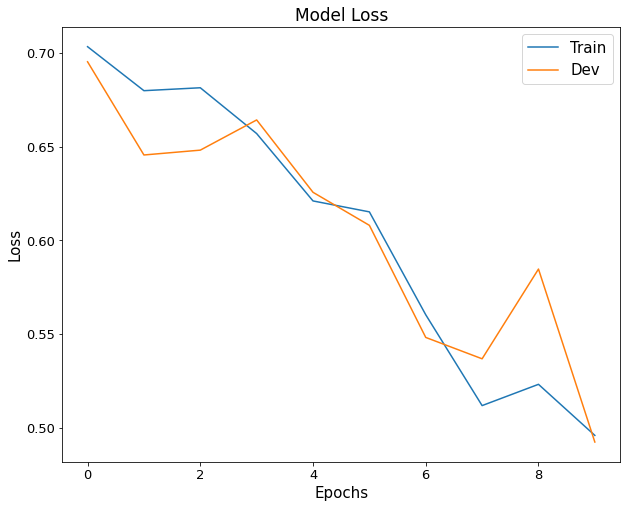

In [ ]:
# Learning Curves Loss-Epochs
plt.figure(figsize=(10,8))
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('Model Loss', fontsize=17)
plt.ylabel('Loss', fontsize=15)
plt.xlabel('Epochs', fontsize=15)
plt.legend(['Train', 'Dev'], fontsize = 15)
plt.xticks(fontsize=13)   # range(-1,6), range(7), 
plt.yticks(fontsize=13)
# plt.grid()
plt.show()

Experimental characteristics-results

In [ ]:
def report(x, y, set_type):
  probs_belong_to_class_1 = model5.predict(x)
  probs_belong_to_class_0 = 1-probs_belong_to_class_1
  predict_proba_preds = np.concatenate((probs_belong_to_class_0, probs_belong_to_class_1), axis = 1)

  print(f"\nPrecision, recall, F1 scores for each class({set_type} set)")
  print(classification_report(y, np.round(model5.predict(x)).astype("int32"), labels=np.array([0,1])))
                                    # (model.predict(x_train_svd) >= 0.5).astype("int32")

  print(f"\nPrecision Recall AUC score for the negative class({set_type} set):")
  precision, recall, thresholds = precision_recall_curve(y, predict_proba_preds[:,0],pos_label=0)
  area_train_1 = auc(recall, precision)
  print(area_train_1)
  print(f"\nPrecision Recall AUC score for the positive class({set_type} set):")
  precision, recall, thresholds = precision_recall_curve(y, predict_proba_preds[:,1],pos_label=1)
  area_train_2 = auc(recall, precision)
  print(area_train_2)
  print(f"\nMacro-averaged Precision Recall AUC score for the {set_type} set:")
  print((area_train_1+area_train_2)/2)

In [ ]:
report(train_data, y_train_1_hot, "train")


Precision, recall, F1 scores for each class(train set)
              precision    recall  f1-score   support

           0       0.87      0.82      0.84       425
           1       0.82      0.87      0.85       406

    accuracy                           0.84       831
   macro avg       0.85      0.85      0.84       831
weighted avg       0.85      0.84      0.84       831


Precision Recall AUC score for the negative class(train set):
0.90787285206513

Precision Recall AUC score for the positive class(train set):
0.9131592110546792

Macro-averaged Precision Recall AUC score for the train set:
0.9105160315599046


In [ ]:
report(val_data, y_val_1_hot, "validation")


Precision, recall, F1 scores for each class(validation set)
              precision    recall  f1-score   support

           0       0.77      0.70      0.73       137
           1       0.73      0.79      0.76       140

    accuracy                           0.75       277
   macro avg       0.75      0.75      0.75       277
weighted avg       0.75      0.75      0.75       277


Precision Recall AUC score for the negative class(validation set):
0.846573705885053

Precision Recall AUC score for the positive class(validation set):
0.8266069138575395

Macro-averaged Precision Recall AUC score for the validation set:
0.8365903098712962


In [ ]:
report(test_data, y_test_1_hot, "test")


Precision, recall, F1 scores for each class(train set)
              precision    recall  f1-score   support

           0       0.75      0.75      0.75       130
           1       0.78      0.78      0.78       148

    accuracy                           0.76       278
   macro avg       0.76      0.76      0.76       278
weighted avg       0.76      0.76      0.76       278


Precision Recall AUC score for the negative class(train set):
0.8262165314894183

Precision Recall AUC score for the positive class(train set):
0.8618548687403423

Macro-averaged Precision Recall AUC score for the train set:
0.8440357001148804
